# CS598 Deep Learning for Healthcare Final Project
## Reproduction of Deepr: A Convolutional Net for Medical Records
### Juan Alvarez Martinez, Shane Sepac

## Reproducibility Summary
We implemented *Deepr: A Convolutional Net for Medical Records* and achieved an AUC in the model validation consistent and if not better than the original paper reported. The MIMIC-3 dataset was used for testing against the Deepr paper. The python library *Pyhealth* was used to ingest the MIMIC-3 dataset in order to leverage patient, visit and event level data. These data were mapped into "sentences," as referenced in the paper, which were formed by capturing the ICD-9 diagnoses and procedure codes for events within a given visit into "phrases", and each phrase concatenated between a timestamp indicating duration between patient visits. After generating sentences according to every patient's EMR records, we generated word embeddings for each sentence via Word2Vec (skip-gram), which was leveraged to help capture the context of surrounding words. The embeddings were pushed through our Deepr model implementation, which consists of convolutional, relu, max pooling and linear classification layers, which produced a binary classification of unplanned readmission likelihood. The data used to train the model was a 1-1 mixture of unplanned readmitted and non-readmitted patients. During validation, we achieved results consistent with the Deepr paper, with an AUC of ~0.85.

## Load MIMIC-III Dataset. 
Several csv files are needed from the MIMIC-III dataset: ADMISSIONS, PATIENTS, DIAGNOSES_ICD, and PROCEDURES_ICD. These files can be loaded automatically out of S3, or you can place them in `<project_root>/mimic3`. 
- If loading out of S3, ensure you have all environment variables from .env.sample copied and instantiated in a .env file!

In [ ]:
# install the required dependencies
%pip install boto3 python-dotenv pandas pyhealth matplotlib

### Get MIMIC-3 Data
Attempt to load MIMIC-3 data out of S3 if the relevant CSV files are not already in the mimic3 folder at the project root.

In [3]:
import os
from utils import copy_file_from_s3

data_folder = "mimic3"
required_files = ["ADMISSIONS.csv", "PATIENTS.csv", "DIAGNOSES_ICD.csv", "PROCEDURES_ICD.csv", "TRANSFERS.csv"]

for i, fn in enumerate(required_files):
  if not os.path.exists(f"{data_folder}/{fn}"):
    print(f"Cannot find {fn} in {data_folder}, trying to download from S3...")
    copy_file_from_s3(fn, data_folder)
  else:
    print(f"Found {fn}...")

Found ADMISSIONS.csv...
Found PATIENTS.csv...
Found DIAGNOSES_ICD.csv...
Found PROCEDURES_ICD.csv...
Found TRANSFERS.csv...


In [4]:
from pyhealth.datasets import MIMIC3Dataset

mimic3_ds = MIMIC3Dataset("./mimic3/", ["DIAGNOSES_ICD", "PROCEDURES_ICD"]) #pyhealth does not support mapping ICD-9 to ICD-10 codes.

mimic3_ds.info()
mimic3_ds.stat()


dataset.patients: patient_id -> <Patient>

<Patient>
    - visits: visit_id -> <Visit> 
    - other patient-level info
    
    <Visit>
        - event_list_dict: table_name -> List[Event]
        - other visit-level info
    
        <Event>
            - code: str
            - other event-level info


Statistics of base dataset (dev=False):
	- Dataset: MIMIC3Dataset
	- Number of patients: 46520
	- Number of visits: 58976
	- Number of visits per patient: 1.2678
	- Number of events per visit in DIAGNOSES_ICD: 11.0384
	- Number of events per visit in PROCEDURES_ICD: 4.0711



'\nStatistics of base dataset (dev=False):\n\t- Dataset: MIMIC3Dataset\n\t- Number of patients: 46520\n\t- Number of visits: 58976\n\t- Number of visits per patient: 1.2678\n\t- Number of events per visit in DIAGNOSES_ICD: 11.0384\n\t- Number of events per visit in PROCEDURES_ICD: 4.0711\n'

## Sequencing EMR: Creating Sentences representing patient episodes
Per Deepr, an EMR must be translated into a sentence for use downstream the model. An EMR is a sequence of time-stamped visit episodes. Each episode involves a series of diagnoses and treatments, called a phrase. Each phrase is separated by a time interval equal to `(0–1], (1–3], (3–6], (6–12], and 12+` or `TRANSFER`, with the latter indicating a transfer between care providers (separate departments within the same hospital or between hospitals.) Infrequent words are coded with `RAREWORD`, which indicates the word has appeared <100 times. Per the Deepr paper, an example sentence looks as follows:

```
1910 Z83 911 1008 D12 K31 1-3m R94 RAREWORD H53 Y83 M62 Y92 E87 T81 RAREWORD RAREWORD 1893 D12 S14 738 1910 1916 Z83 0-1m T91 RAREWORD Y83 Y92 K91 M10 E86 6-12m K31 1008 1910 Z13 Z83.
```

Note: In the sentence above, diagnoses are in ICD-10 format (a character followed by digits) and procedures are in digits. 

The MIMIC-3 dataset provides ICD-9 codes, and these will be used, but the level-3 variant of them for consistency with the original paper. It can also be noted that the encounter and discharge datetimes for visits are between the years 2100-2200 in order to deidentify patients, however, the time interval between visits is indeed preserved.


In [5]:
'''
Find rare words (diagnoses and procedures with counts of less than 100)
'''
word_cnts = {}

for i, p in enumerate(mimic3_ds.patients.values()):
  words = []

  for _, v in p.visits.items():
    for e in v.get_event_list('DIAGNOSES_ICD'):
      words.append(e.code)

    for e in v.get_event_list('PROCEDURES_ICD'):
      words.append(e.code)

  for word in words:
    # If the word is already in the dictionary, increment the count
    if word in word_cnts:
        word_cnts[word] += 1
    # Otherwise, add the word to the dictionary with a count of 1
    else:
        word_cnts[word] = 1

In [6]:
'''
Append to pyhealth's record of visits so that ADMISSION_TYPE and ADMISSION_LOCATION data are available. The former is used later in the model training
to target against readmission (by looking at non-elective admits) and the latter is used to discern intra/inter hospital transfers, which is needed to build 
the sentences already described (i.e. to help build sentences using the TRANSFER keyword.)
'''
import pandas as pd

admissions_df = pd.read_csv("./mimic3/ADMISSIONS.csv")
admissions_df = admissions_df.set_index("HADM_ID")

for i, p in enumerate(mimic3_ds.patients.values()):
  # Sort patient visits by encounter_time
  for i, v in enumerate(p.visits.items(),):
    res = admissions_df.loc[int(v[1].visit_id)]

    v[1].attr_dict["ADMISSION_TYPE"] = res["ADMISSION_TYPE"]
    v[1].attr_dict["ADMISSION_LOCATION"] = res["ADMISSION_LOCATION"]

In [7]:
from utils import timedelta_to_interval
import random
import json

'''
Translate EMRs into sentences outlined by the paper. A sentence consists of phrases, which are randomly shuffled diagnosis and procedure codes, separated by the 
time interval between visits, if the time interval exists. Sentences should have 100 words max.

While looping over each patient:
  1. Sort visits by encounter_time
  2. Find the time interval between each visit and generate its relevant string word
  3. Build arrays of diagnosis and procedure codes for each visit, replacing ICD-10 codes with less than 100 usages with RAREWORD
  4. Randomly shuffle each array of diagnosis and procedure codes, then append the time interval string if available. This represents a phrase.
    Concat each phrase to an array, which will be concatenated to form the final sentence. If the concatenation would form a sentence longer
    than 100 words, min(100, words(sentence)) is adhered to.
'''
sentences = []
for i, p in enumerate(mimic3_ds.patients.values()):

  # Sort patient visits by encounter_time
  sorted_visits = sorted(p.visits.items(), key=lambda v: v[1].encounter_time) # sort by encounter time in order to guage interval between visits

  # Generate timestamps in between visits
  discharge_times = [visit[1].discharge_time for visit in sorted_visits[:-1]]
  encounter_times = [visit[1].encounter_time for visit in sorted_visits[1:]]

  time_intervals = [
      t2 - t1
      for t1, t2 in zip(discharge_times, encounter_times)
  ]

  # Convert timestamps to month intervals as specified in paper
  time_interval_strs = timedelta_to_interval(time_intervals)

  # event_diagnoses_ls = (visit, diagnoses_codes)
  event_diagnoses_ls = []

  # event_procedures_ls = (visit, procedure_codes)
  event_procedures_ls = []

  # Helper function to create arrays with RAREWORD using list comprehension
  def handle_event(event_list, word_cnts):
      return ["RAREWORD" if e.code in word_cnts and word_cnts[e.code] < 100 else e.code for e in event_list]

  # build arrays of diagnoses and procedures on a visit level, add to event_diagnoses_ls or event_procedures_ls
  for _, v in sorted_visits:
      visit_diagnoses = handle_event(v.get_event_list('DIAGNOSES_ICD'), word_cnts)
      event_diagnoses_ls.append(visit_diagnoses)

      visit_procedures = handle_event(v.get_event_list('PROCEDURES_ICD'), word_cnts)
      event_procedures_ls.append(visit_procedures)


  # Randomly shuffle diagnosis and procedure codes and append a time interval after, if available. Ensure the output sentence will not be more than 100 words.
  arrs = []
  word_cnt = 0
  for i, vd in enumerate(event_diagnoses_ls):
      arr = vd + event_procedures_ls[i]
      random.shuffle(arr)
      if i < len(time_interval_strs):
          arr.append(time_interval_strs[i])

      new_word_cnt = word_cnt + len(arr)

      if new_word_cnt > 100:
          # Calculate the number of elements needed to reach exactly 100 words
          elements_needed = 100 - word_cnt

          # Take a subset of arr to make new_word_cnt equal 100
          arr = arr[:elements_needed]
          arrs.append(arr)
          break

      arrs.append(arr)
      word_cnt = new_word_cnt

  # Combine all codes and time interval to create a phrase, representing a visit
  phrases = [" ".join(arr) for arr in arrs]

  # Combine all phrases to create a sentence, representing a sequence as outlined by the paper
  sentence = " ".join(phrases)
  sentences.append(sentence)

# output to json file
output_dir = "data"
output_filename = "sentences.json"

os.makedirs(output_dir, exist_ok=True)

with open(os.path.join(output_dir, output_filename), "w") as json_file:
  json.dump(sentences, json_file)

### Test that output sentences satisfy the following conditions:
- There is a sentence for each patient
- Each sentence is capped to max 100 words
- Multi visit patients have visits separated by a timestamp
- Words should not exist in their ICD-10 form if used less than 100 times (should be replaced with RAREWORD)


In [8]:
import re

# There should be one sentence per patient
num_patients = len(mimic3_ds.patients)
num_sentences = len(sentences)
assert(num_patients == num_sentences)

# There should be max 100 words per sentence
word_lengths = map(lambda s: len(s.split()), sentences)
assert(max(list(word_lengths)) <= 100)

# There should be no word in any of the sentences that is present less than 100 times
rarewords = [word for word, count in word_cnts.items() if count < 100]
for sentence in sentences:
  words_of_sentence = sentence.split()
  rareword_violations = list(filter(lambda w: w in word_cnts and word_cnts[w] < 100, words_of_sentence))
  assert(len(rareword_violations) == 0)


# Patients with multiple visits should have timestamps separating their visits i.e. 1-3m or 12+m #TODO: Add TRANSFER to regex
pattern = re.compile(r"[-+]")
for i, p in enumerate(mimic3_ds.patients.values()):
    if len(p.visits) > 1:
        if not pattern.search(sentences[i]):
            print(f"Failed assertion for sentences[{i}]: '{sentences[i]}'")
            assert(False)


## Training Word2Vec
#TODO: Write description

In [9]:
import nltk
import nltk.corpus
from nltk.stem.snowball import SnowballStemmer
import re


nltk.download("stopwords")


def split_tokens(stemmer, stopwords, line):
    return [
        stemmer.stem(i)
        for i in re.split(r" +", re.sub(r"[^a-z@# ]", "", line.lower()))
        if (i not in stopwords) and len(i)
    ]


stemmer = SnowballStemmer("english")
stopwords = nltk.corpus.stopwords.words("english")
sentences = [
    " ".join(sentence)
    for line in open("data/shakespeare.txt", "r").readlines()
    if (sentence := split_tokens(stemmer, stopwords, line)) and sentence
]

ModuleNotFoundError: No module named 'nltk'

In [10]:
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset


class Word2VecDataset(Dataset):
    def __init__(self, dataset, tok2id, wsize=3):
        self.wsize = wsize
        self.tok2id = tok2id

        self.dataset = [
            ctx
            for sentence in dataset for ctx in self.get_contexts(sentence)
        ]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

    def get_contexts(self, sentence):
        moving_window = []

        for word_ix, word in enumerate(sentence):
            target = self.tok2id[word]
            window = [
                word_ix + win_ix
                for win_ix in range(-self.wsize, self.wsize + 1)
                if (
                    word_ix + win_ix >= 0
                    and word_ix + win_ix < len(sentence)
                    and win_ix != 0
                )
            ]

            moving_window += [
                (target, self.tok2id[sentence[win_word]]) for win_word in window
            ]

        return moving_window


class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.prediction = nn.Linear(embedding_size, vocab_size, bias=False)

    def forward(self, input):
        hidden = self.embedding(input)
        logits = self.prediction(hidden)

        return logits


dataset = [sentence.split(" ") for sentence in sentences]
vocab = set([word for sentence in dataset for word in sentence])

id2tok = dict(enumerate(vocab))
tok2id = {token: id for id, token in id2tok.items()}

word2vec_dataloader = DataLoader(
    Word2VecDataset(dataset, tok2id),
    batch_size=64,
    shuffle=True
)

word2vec_model = Word2Vec(len(vocab), embedding_size=100)

100%|█████████▉| 1458554/1458560 [33:25<00:00, 744.51it/s]

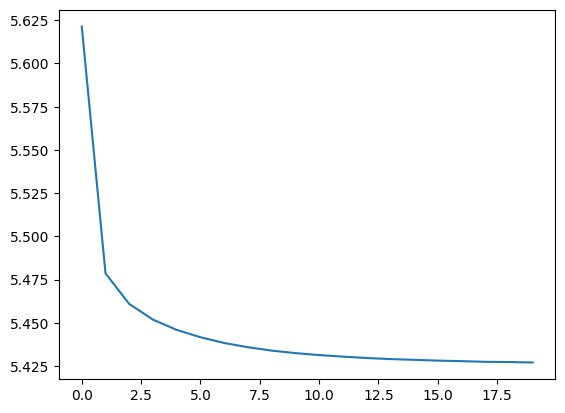

100%|██████████| 1458560/1458560 [33:41<00:00, 744.51it/s]

In [7]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt


LR = 3e-4
EPOCHS = 20

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(word2vec_model.parameters(), lr=LR)
progress_bar = tqdm(range(EPOCHS * len(word2vec_dataloader)))

running_loss = []

for epoch in range(EPOCHS):
    epoch_loss = 0
    for center, context in word2vec_dataloader:
        optimizer.zero_grad()

        logits = word2vec_model(input=context)
        loss = loss_fn(logits, center)
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()
        progress_bar.update(1)

    epoch_loss /= len(word2vec_dataloader)
    running_loss.append(epoch_loss)

plt.plot(running_loss)

In [11]:
from scipy.spatial import distance
import numpy as np


def get_distance_matrix(wordvecs, metric):
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix


def get_k_similar_words(word, dist_matrix, k=10):
    idx = tok2id[word]
    dists = dist_matrix[idx]
    ind = np.argpartition(dists, k)[:k+1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, id2tok[i], dists[i]) for i in ind]
    return out


dmat = get_distance_matrix(
    word2vec_model.prediction.weight.cpu().detach().numpy(),
    "cosine"
)

test_sentence = ["good", "father" "school", "hate"]

for word in test_sentence:
    print(word, [token[1] for token in get_k_similar_words(word, dmat)], "\n")

KeyError: 'good'

In [8]:
weights = word2vec_model.state_dict()
torch.save(weights, os.path.join(output_dir, "word2vec.pt"))

## Convolutional Network
Now that Word2Vec has created embeddings for the sentences we generated in the first step, we are ready to pass the embeddings through a convolutional layer, followed by max pooling.

First, we will generate the train and val loaders. This will first require us to create the validation set. In Deepr, we try to predict the likelihood of unplanned re-admission after both 3 and 6 months. Unplanned re-admission is coded in the database as an unplanned or emergency with the status not equal to "elective" or a transfer from another hospital.

Next, we will define a model containing a convolutional network, ReLU and max pooling layer.

Deepr reported the following parameters were determined to be optimal for the model:

`m = 100, d = 1, motif size = 3, 4, and 5, n = 100 number of epochs = 10, minibatch size = 64, and l2 regularization λ = 1.0.`

In [12]:
'''
Create validation dataset, train and val loaders for training Deepr.
'''

val_readmission_time_days = 180 # The threshold for flagging unplanned readmission for validation set
risk_group = []
remaining_group = [] #patients not put into the risk group
for i, p in enumerate(mimic3_ds.patients.values()):

  # Sort patient visits by encounter_time
  sorted_visits = sorted(p.visits.items(), key=lambda v: v[1].encounter_time) # sort by encounter time in order to guage interval between visits

  # Generate timestamps in between visits
  discharge_times = [visit[1].discharge_time for visit in sorted_visits[:-1]]
  encounter_times = [visit[1].encounter_time for visit in sorted_visits[1:]]

  time_intervals = [
      t2 - t1
      for t1, t2 in zip(discharge_times, encounter_times)
  ]

  visit_types = [visit[1].attr_dict["ADMISSION_TYPE"] for visit in sorted_visits[1:]]

  unplanned_readmissions = [
      i_vt
      for i_vt, (interval, visit_type) in enumerate(zip(time_intervals, visit_types))
      if interval.days <= val_readmission_time_days and visit_type == "EMERGENCY"
  ]

  if unplanned_readmissions:
    risk_group.append(sentences[i])
  else: 
    remaining_group.append(sentences[i])


In [14]:
# Risk group patients should be separate from the candidate group, and sum to the length of the total dataset
assert(len(mimic3_ds.patients.values()) == len(risk_group) + len(remaining_group))

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader

'''
Dataset for Deepr model. __getitem__ returns the word indices for a given sentence. 
DeeprModel will then look up the word embeddings by the index in the embedding table.
'''

class DeeprDataset(Dataset):
    def __init__(self, x_data, y_data, word2index):
        self.x_data = x_data
        self.y_data = y_data
        self.word2index = word2index

    def get_indices(self, sentence):
        return torch.tensor([self.word2index[word] for word in sentence.split()])

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.get_indices(self.x_data[idx])
        y = self.y_data[idx]
        return x, y

In [15]:
from torch.nn.utils.rnn import pad_sequence

'''
The sentences in each batch will likely not all be the same size, and thus we need to pad the sentences. 
DeeprDataset returns the indicies of the words in each sentence. We will padd these vectors of indicies with 0s.
It is important later on ensure that index 0 of the embedding table is a torch.zero(embedding_dim), as these are just placeholder values,
and to mask them out later on.
'''

def pad_collate(batch):
    x_data, y_data = zip(*batch)
    x_data_padded = pad_sequence(x_data, batch_first=True, padding_value=0)
    # Create binary mask
    mask = (x_data_padded != 0).float()

    # Convert from tuple to tensor
    y_data_tensor = torch.tensor(y_data, dtype=torch.long)

    return x_data_padded, y_data_tensor, mask

In [16]:
import random
import numpy as np

'''
Generate the training and validation sets. The training data is a 1-1 mixture of risk and control patients, where x 
is the sentence of the patient, and y is the corresponding binary label of readmission (1=readmit, 0=non-readmit)

We also ensure that index 0 of the embedding table is associated with the word "<pad>", so that the padding index has an associated word, 
as it was not learned in Word2Vec, but will be used in the Deepr model later on.
'''

train_ratio = 0.8

control_group = random.sample(remaining_group, len(risk_group))
control_labels = [0] * len(control_group)
control_zip = list(zip(control_group, control_labels))

risk_labels = [1] * len(risk_group)
risk_zip = list(zip(risk_group, risk_labels))

all_zip = list(control_zip + risk_zip)
random.shuffle(all_zip)

train_dataset = all_zip[:int(len(all_zip)*train_ratio)]
val_dataset = all_zip[int(len(all_zip)*train_ratio):]

x_train, y_train = zip(*train_dataset)
x_val, y_val = zip(*val_dataset)

# Shift all elements up, and add the padding word at index 0
word2index = {word: idx+1 for idx, word in enumerate(tok2id)}
word2index["<pad>"] = 0

train_dataset = DeeprDataset(x_train, y_train, word2index)
val_dataset = DeeprDataset(x_val, y_val, word2index)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=pad_collate)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True, collate_fn=pad_collate)



In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

'''
DeeprModel does the following things:

1. During initialization, updates the embedding table learned from Word2Vec to include the embedding for padding.
2. Pretrains an embedding layer with the weights from Word2Vec.
3. Initializes the model with hyperparameters from the Deepr paper, mentioned at the beginning of this section.
4. Passes the embeddings through convolutional, max pooling and a linear classifier.
'''

class DeeprModel(nn.Module):
    def __init__(self, word_embeddings_dict, word2index, embedding_dim, num_filters, window_size, num_classes):
        super(DeeprModel, self).__init__()

        # Prepare the embedding matrix; this takes the ouput of word2vec but inserts "<pad>" string, assigning an empty embedding to it
        embedding_matrix = torch.zeros(len(word_embeddings_dict) + 1, embedding_dim)
        for word, index in word2index.items():
            if word != "<pad>":
                embedding_matrix[index] = torch.tensor(word_embeddings_dict[word])

        # Layers
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, padding_idx=0, freeze=True)
        self.conv = nn.Conv1d(embedding_dim, num_filters, window_size)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(num_filters, num_classes)

    def forward(self, x, mask):
        x = self.embedding(x)  # Shape: (batch_size, sequence_length, embedding_dim)
        x = x.transpose(1, 2)  # conv requires input_channels to be dim 1. Shape: (batch_size, embedding_dim, sequence_length)

        # Add padding to x, because convolution will reduce dimensionality and make multiplication with the mask impossible due to size mismatch
        padding_size = self.conv.kernel_size[0] - 1
        x = F.pad(x, (padding_size, 0))  # Pad the input tensor on the left side

        x = F.relu(self.conv(x))  # Shape: (batch_size, num_filters, sequence_length)

        x = x * mask.unsqueeze(1) # Apply mask

        relu_output = x.detach().cpu().numpy() # used in motif detection analysis later; not part of training/validation

        x = self.pool(x).squeeze(2)  # Shape: (batch_size, num_filters)

        x = self.fc(x)  # Shape: (batch_size, num_classes)
        return x, relu_output

## Training and validating DeeprModel

In [59]:
'''
This function is a helper function to take the output of the filter responses (ReLU(CNN(x)) in Deepr's forward method) and map them back to the original sentences. 
Strong filter responses are indicative that the motif within the convolutional window contributes towards the model predicting unplanned hospital readmission.
'''

# Remaps tok2id to include the padding index used in Deepr.
index2WordValidation = {idx+1: word for idx, word in enumerate(tok2id)}
index2WordValidation[0] = '<pad>'

# Helper function
def normalize_array(arr, max_val):
    min_val = 0
    normalized = [1 + (x - min_val) * (2 - 1) / (max_val - min_val) for x in arr]
    return normalized

def getMotifs(batch_x, relu_output, probabilities, filter_num=0):
    '''
    batch_x contains the batch in the validation loop (shape: batch_size, padded_sentence_length)
    relu_output contains the filter responses from Deepr (shape: batch_size, num_filters, padded_sentence_length)
    probabilities contains the probabilities of the sentences being in the positive class (positive readmit probability). (shape: batch_size)
    filter_num is a 0 indexed number corresponding to which filter from the CNN the motifs should be pulled from.
    '''

    output_list = []
    for i in range(batch_x.size(0)):
      # Remap indices from tensors in batch back to their original sentences
      word_list = [index2WordValidation[idx.item()] for idx in batch_x[i]]
      relu_values = relu_output[i][filter_num].tolist()
      is_positive = probabilities[i] > 0.5

      instance_data = {
          "sentence": word_list,
          "is_positive": bool(is_positive),
          "is_positive_score": probabilities[i].item(),
          "raw_motif_values": relu_values
      }
    
      output_list.append(instance_data)
      
    return output_list

def normalize_motifs(motifs, max_motif_val):
  for i in range(len(motifs)):
    normalized_motifs = normalize_array(motifs[i]["raw_motif_values"], max_motif_val)
    motifs[i]["normalized_motif_values"] = normalized_motifs
  return motifs


In [60]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import json

'''
We first initialize the model's hyperparameters. Then, we load the saved weights from Word2Vec into a new word2vec_model instance. 
We initialize a DeeprModel instance, CrossEntropyLoss function, and SGD optimizer, the later two being specified in the Deepr paper.
In the training loop, we compare the logits computed in the forward method of the model against the labels we computed in other steps,
compute the loss, back propogate and update weights.

In validating the data, we compute validation loss and AUC.

'''

# Hyperparameters
num_epochs = 5
learning_rate = 1e-3
l2_reg = 1.0

# Initialize the model
num_filters = 64
filter_size = 3
num_classes = 2  # For binary classification
embedding_dim = 100

# Load weights from .pt file
vocab_size = len(vocab)
word2vec_model = Word2Vec(vocab_size, embedding_dim)
weights_path = os.path.join(output_dir, "word2vec_time.pt")
saved_weights = torch.load(weights_path)

word2vec_model.load_state_dict(saved_weights)

word_embeddings_dict = {
    word: word2vec_model.embedding(torch.tensor(tok2id[word])).detach().numpy()
    for word in tok2id
}

model = DeeprModel(word_embeddings_dict, word2index, embedding_dim, num_filters, filter_size, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2_reg)
max_motif_val = 0.0
motifs_data = []

# Training loop
for epoch in range(num_epochs):
    for batch_x, batch_y, mask in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        logits, _relu_output = model(batch_x, mask)

        # Calculate the loss
        loss = criterion(logits, batch_y)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

    # Validation
    with torch.no_grad():
        val_loss = 0
        all_logits = []
        all_labels = []
        
        for batch_x, batch_y, mask in val_dataloader:
            logits, relu_output = model(batch_x, mask)
            
            loss = criterion(logits, batch_y)
            val_loss += loss.item()
            
            # Get probabilities for the positive class
            probabilities = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()

            # Output motifs data for each sentence in the batch
            batch_motifs = getMotifs(batch_x, relu_output, probabilities)
            motifs_data.extend(batch_motifs)
            # find max value of the batch and update the max motif value across the validation set
            max_batch_motif_val = np.max(relu_output)
            max_motif_val = max(max_batch_motif_val, max_motif_val)

            all_logits.extend(probabilities)
            all_labels.extend(batch_y.cpu().numpy())
        
        val_loss /= len(val_dataloader)
        auc = roc_auc_score(all_labels, all_logits)
        print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}, AUC: {auc:.4f}")

# Normalize the motifs across the validation set
motifs_data_normalized = normalize_motifs(motifs_data, max_motif_val)
# sort the motifs from most at risk of unplanned readmit to least
motifs_data_normalized = sorted(motifs_data_normalized, key=lambda x: x['is_positive_score'], reverse=True)

# Save the sentence level motifs to a JSON file
with open(os.path.join(output_dir, "motifs_data.json"), "w") as outfile:
    json.dump(motifs_data_normalized, outfile)


Epoch 1/5, Validation Loss: 0.6924, AUC: 0.6688
Epoch 2/5, Validation Loss: 0.6902, AUC: 0.6990
Epoch 3/5, Validation Loss: 0.6887, AUC: 0.7297
Epoch 4/5, Validation Loss: 0.6880, AUC: 0.7571
Epoch 5/5, Validation Loss: 0.6876, AUC: 0.7796
